### Using LightGBM to predict the yield for a trade from reference data

Version dated August 2, 2021, most recently edited by Charles Elkan.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 80)

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import os
import numpy as np
from google.cloud import bigquery

from lightgbm import LGBMRegressor
import lightgbm

tqdm.pandas()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../eng-reactor-287421-112eb767e1b3.json"

The _reload_ operation below activates changes in the functions defined in _prices.py_.

In [2]:
import prices
import importlib
importlib.reload(prices)

loading prices module
loading prices module


<module 'prices' from '/Users/elkan/ficc/notebooks/prices.py'>

The following transformations make trade records more readable. Note that many of the coupon frequencies occur rarely or even never in the data.
In particular, the coupon frequency is every six months for over 95% of trades.
The function _transform_ keeps the number of records unchanged, operating in-place on its argument.
Also note that performing the coupon frequency mapping twice is incorrect.

In [16]:
COUPON_FREQUENCY_DICT = {0:None,
                         1:2,      # two payments per year
                         2:12,
                         3:1,
                         4:52,
                         5:4,
                         6:0.5,
                         7:1/3,
                         8:1/4,
                         9:1/5,
                         10:1/7,
                         11:1/8,
                         12:26,
                         13:None,
                         14:360,
                         16:0,
                         23:None}

def transform(df):
    df['interest_payment_frequency'] = df['interest_payment_frequency'].map(COUPON_FREQUENCY_DICT)
    
    prices = ['coupon_rate', 'par_traded', 'dollar_price', 'next_call_price', 'par_call_price', 'refund_price']
    for field in prices: df[field] = df[field].astype(float)
        
    dates = ['trade_date', 'dated_date', 'settlement_date', 'first_coupon_date', 
              'next_call_date', 'par_call_date', 'refund_date', 'maturity_date']
    for field in dates: df[field] = pd.to_datetime(df[field])
    return df

The SQL query below uses the flat table that is the output of a team member's pipelines. 
No trades are excluded, but we only take the most recent information for each trade.
For dates in the past, this query avoids some erroneous information because MSRB has published corrected trade messages.
However, there exist incorrect messages that remain permanently in the data.

Why _issue__amount_ and _issue__size_ are different is unknown.

For each trade, we compute the price and the type of repayment date assumed to obtain this price.
An M1 MacBook Air performs about 2200 price calculations per second.

In [4]:
def get_trade_data(bqclient, first_date, last_date="", usebq=False):
    savedfile = "gbmdata.pkl"
    if last_date == "": last_date = first_date
    query = f''' SELECT
        cusip,

        num_prev_messages,
        when_issued,
        brokers_broker,
        is_alternative_trading_system AS is_ATS,
        is_non_transaction_based_compensation AS is_NTBC,
        conduit_obligor_name AS obligor,
        callable_at_cav,
        max_amount_outstanding AS issue_size,
        issue_amount,

        muni_security_type AS security_type,
        other_enhancement_type AS enhancement,
        purpose_class AS purpose,
        purpose_sub_class AS purpose_sub,

        trade_date,
        trade_type,
        par_traded,
        dollar_price,
        yield,
        yield_spread,
        coupon AS coupon_rate,
        interest_payment_frequency,
        dated_date,
        settlement_date, 
        first_coupon_date,
        is_callable,
        next_call_date,
        next_call_price,
        par_call_date,
        par_call_price,
        is_called,
        called_redemption_type AS redemption_type,
        refund_date,
        refund_price,
        maturity_date,
        sp_long AS rating,
        organization_primary_name AS issuer,
        is_lop_or_takedown AS is_LOPT,
        incorporated_state_code AS state,
        security_description AS description,
        instrument_primary_name AS primary,
        is_general_obligation AS is_GO,
        capital_type,
        use_of_proceeds,
        federal_tax_status AS tax_status
        FROM `eng-reactor-287421.primary_views.trade_history_with_reference_data`
        WHERE MSRB_valid_to_date > current_date
        AND trade_date BETWEEN '{first_date}' AND '{last_date}'
        ORDER BY trade_date ASC
     '''
    
    if usebq:
        print("getting data from BigQuery")
        df = bqclient.query(query).result().to_dataframe()
        df.to_pickle(savedfile)     
        df['alert'] = False
        df = transform(df)
        df['my_price'], df['my_date'] = zip(*df.progress_apply(lambda x: prices.compute_price(x),axis=1))
        df.to_pickle(savedfile)     
    else:
        if os.path.isfile(savedfile):
            print("getting pickled data from " + savedfile)
            df = pd.read_pickle(savedfile)
        else:
            print("cannot find saved data at " + savedfile)
            df = None
    return df 

In [5]:
bqclient = bigquery.Client()
%time vanilla = get_trade_data(bqclient, '2021-01-04', '2021-01-31', usebq=False)
len(vanilla)

getting pickled data from gbmdata.pkl
CPU times: user 189 ms, sys: 64.7 ms, total: 253 ms
Wall time: 253 ms


603479

Dates are converted into durations, measured in years or days.
Bonds with deferred interest are a superset of zero-coupon bonds.

In [6]:
def period(p): return p.dt.days / 365.25

vanilla['yrs_to_call'] = period(vanilla.next_call_date - vanilla.settlement_date)
vanilla['yrs_to_par_call'] = period(vanilla.par_call_date - vanilla.settlement_date)
vanilla['yrs_to_maturity'] = period(vanilla.maturity_date - vanilla.settlement_date)
vanilla['call_to_maturity'] = period(vanilla.maturity_date - vanilla.next_call_date)

vanilla['days_to_settle'] = period(vanilla.settlement_date - vanilla.trade_date) * 365.25 
vanilla['days_to_refund'] = period(vanilla.refund_date - vanilla.settlement_date) * 365.25

vanilla['zerocoupon'] = vanilla.coupon_rate == 0
vanilla['deferred'] = vanilla.interest_payment_frequency == 0

The column _yrs__to__end_ is used later to identify the largest errors, but not used for training.
The function _end__date_ duplicates code from _prices.py_, which it should not do.

In [7]:
def end_date(trade):
    if trade.my_date == "refunding": 
        if pd.isnull(trade.refund_date):
            if trade.redemption_type in [1,5]:
                d = trade.maturity_date
            else:
                d = trade.next_call_date
        else:
            d = trade.refund_date
    elif trade.my_date == "next call": d = trade.next_call_date
    elif trade.my_date == "par call":  d = trade.par_call_date
    elif trade.my_date == "maturity":  d = trade.maturity_date
    else: d = None
    return d

%time vanilla['last_date'] = vanilla.apply(end_date, axis=1)
vanilla['yrs_to_end'] = period(vanilla.last_date - vanilla.settlement_date)

CPU times: user 13.2 s, sys: 204 ms, total: 13.4 s
Wall time: 13.4 s


We exclude bonds with unreliable data, i.e., bonds whose price cannot be reproduced or whose yield is unrealistically small or large.

In [8]:
def prune(df, keep):
    denom = len(vanilla)
    num = sum(keep)
    print("removed", denom-num, "from", denom, "kept", 100*num/denom, "%")
    return df[keep]

vanilla['price_delta'] = abs(vanilla.my_price - vanilla.dollar_price)
tol = 0.005
vanilla = prune(vanilla, vanilla.price_delta < tol)

vanilla = prune(vanilla, vanilla.par_traded <= vanilla.issue_amount)
vanilla = prune(vanilla, vanilla['yield'] > 0)
vanilla = prune(vanilla, vanilla['yield'] < 4)

removed 20336 from 603479 kept 96.63020585637611 %
removed 18 from 583143 kept 99.99691327856118 %
removed 1025 from 583125 kept 99.82422293676314 %
removed 10111 from 582100 kept 98.2630132279677 %


The issuer of a bond is identified by the first six characters of the cusip, and _proxy_ is a Boolean for whether the true borrower (i.e., the obligor) is different from the issuer.

In [9]:
vanilla['cusip6'] = vanilla.cusip.str[0:6]
vanilla['proxy'] = ~pd.isnull(vanilla.obligor)

We select features of three types to use for training.
Binary and categorical features are in fact treated identically.

The label to be predicted here is the yield spread. 
Slightly better accuracy is achieved when predicting this rather than yield to worst,
which indicates that adjusting for the yield curve is valuable.
This adjustment will be more valuable when using a longer period of training data.
However, we need to find a more accurate yield curve to use.

In [10]:
BINARY = ['is_callable', 'is_called', 'zerocoupon', 'deferred', 'is_LOPT', 'is_GO']
BINARY += ['when_issued', 'brokers_broker', 'is_ATS', 'is_NTBC', 'callable_at_cav', 'proxy']
CATEGORICAL = ['trade_type', 'redemption_type', 'rating', 'state', 'capital_type', 'use_of_proceeds', 'tax_status']
CATEGORICAL += ['security_type', 'enhancement', 'purpose', 'purpose_sub']
NUMERICAL = ['days_to_settle', 'yrs_to_call', 'yrs_to_par_call', 'days_to_refund', 'call_to_maturity']
NUMERICAL += ['par_traded', 'coupon_rate', 'next_call_price', 'par_call_price', 'refund_price', 'yrs_to_maturity']
NUMERICAL += ['num_prev_messages', 'issue_amount']
FEATURES = BINARY + CATEGORICAL + NUMERICAL

TARGET = 'yield_spread' # 'yield' # 

for f in BINARY + CATEGORICAL:
    vanilla[f] = vanilla[f].astype('category')

The dataset is sorted in increasing order by trade date, so the latest 20% of the dataset is used for measuring out-of-sample accuracy, 
and the model is trained on the earlier 80%.
Training to minimize MSE yields better MAE than training to minimize MAE.

In [17]:
EVALFRAC = 0.2
train_index = int( len(vanilla) * (1-EVALFRAC) )

model = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mse', verbosity=-1)
%time model.fit(vanilla[FEATURES][0:train_index],vanilla[TARGET][0:train_index], sample_weight=vanilla['yrs_to_end'][0:train_index])

%time vanilla['predicted'] = model.predict(vanilla[FEATURES])
vanilla['delta'] = vanilla[TARGET] - vanilla.predicted
evalset = vanilla[train_index:]
evalset.delta.mean(), evalset.delta.abs().mean()

/Users/elkan/miniforge3/envs/tf25/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 46.8 s, sys: 9.1 s, total: 55.9 s
Wall time: 7.35 s
CPU times: user 30.8 s, sys: 695 ms, total: 31.5 s
Wall time: 4.07 s


(-0.013047508427004428, 0.142227066239436)

The following figure shows how often each feature is used in the model. 
It is not clear which of these features are used so rarely that in fact they are do not improve accuracy.
It is surprising that _issue__amount_ and _state_ are the top two features.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

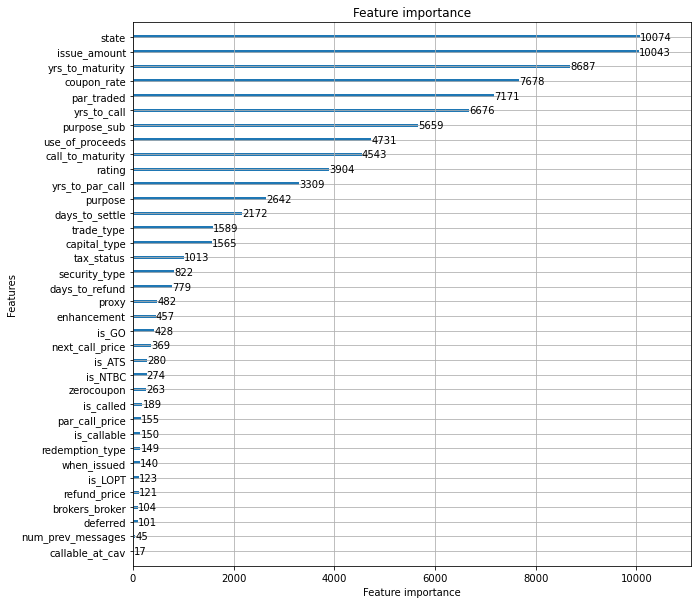

In [12]:
lightgbm.plot_importance(model, figsize=(10,10))

The magnitude of an error in dollars is approximately the error in yield times the size of the trade times the duration until the bond is paid back.
The largest errors are around +/- $1M and are for bonds with more than 20 years until redemption.

In [18]:
vanilla['dollerr'] = vanilla.delta * vanilla.par_traded * vanilla.yrs_to_end / 100
vanilla.sort_values('dollerr')

,cusip,num_prev_messages,when_issued,brokers_broker,is_ATS,is_NTBC,obligor,callable_at_cav,issue_size,issue_amount,security_type,enhancement,purpose,purpose_sub,trade_date,trade_type,par_traded,dollar_price,yield,yield_spread,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,rating,issuer,is_LOPT,state,description,primary,is_GO,capital_type,use_of_proceeds,tax_status,alert,my_price,my_date,yrs_to_call,yrs_to_par_call,yrs_to_maturity,call_to_maturity,days_to_settle,days_to_refund,zerocoupon,deferred,last_date,yrs_to_end,price_delta,cusip6,proxy,predicted,delta,dollerr
4682,913366KB5,1,False,NaN,False,False,None,False,650000000.0,1.800000e+09,8,NaN,17.0,48.0,2021-01-25,S,44365000.0,106.928,2.660,2.255886,3.006,2.0,2020-03-05,2021-01-27,2020-05-15,True,2049-11-15,100.0,2049-11-15,100.0,False,NaN,NaT,NaN,2050-05-15,AA-,UNIV CALIF REGTS MED CTR POOLED REV,False,CA,UNIV CALIF REGTS MED CTR POOLED REV TAXABLE-SER N,TAXABLE BDS 2020 SER N,False,6,28,3,False,106.928,next call,28.799452,28.799452,29.295003,0.495551,2.0,NaN,False,False,2049-11-15,28.799452,0.000,913366,False,2.334957,-0.079070,-1.010273e+06
8230,913366KB5,1,False,NaN,False,False,None,False,650000000.0,1.800000e+09,8,NaN,17.0,48.0,2021-01-25,P,50000000.0,106.677,2.672,2.267886,3.006,2.0,2020-03-05,2021-01-27,2020-05-15,True,2049-11-15,100.0,2049-11-15,100.0,False,NaN,NaT,NaN,2050-05-15,AA-,UNIV CALIF REGTS MED CTR POOLED REV,False,CA,UNIV CALIF REGTS MED CTR POOLED REV TAXABLE-SER N,TAXABLE BDS 2020 SER N,False,6,28,3,False,106.678,next call,28.799452,28.799452,29.295003,0.495551,2.0,NaN,False,False,2049-11-15,28.799452,0.001,913366,False,2.320638,-0.052751,-7.596011e+05
4925,6461366S5,1,False,NaN,False,False,None,False,447920000.0,1.566110e+09,8,NaN,48.0,17.0,2021-01-22,S,16210000.0,112.326,3.321,2.915567,4.131,2.0,2019-12-18,2021-01-26,2020-06-15,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2042-06-15,BBB,NEW JERSEY ST TRANSN TR FD AUTH,False,NJ,NEW JERSEY ST TRANSN TR FD AUTH TAXABLE-TRANSN...,SYS TAXABLE BDS 2019 B,False,2,56,3,False,112.329,maturity,NaN,NaN,21.382615,NaN,4.0,NaN,False,False,2042-06-15,21.382615,0.003,646136,False,3.068421,-0.152854,-5.298098e+05
4148,57421CAW4,1,False,NaN,False,False,UNIVERSITY OF MARYLAND MED SYS,False,300000000.0,7.526800e+08,8,NaN,17.0,48.0,2021-01-28,S,10000000.0,105.527,2.916,2.560783,3.197,2.0,2020-07-22,2021-02-01,2021-01-01,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2050-07-01,A,MARYLAND ST HEALTH & HIGHER EDL FACS AUTH REV,False,MD,MARYLAND ST HEALTH & HIGHER EDL FACS AUTH REV ...,TAXABLE BDS 2020 D,False,2,28,3,False,105.523,maturity,NaN,NaN,29.409993,NaN,4.0,NaN,False,False,2050-07-01,29.409993,0.004,57421C,True,2.733024,-0.172241,-5.065594e+05
19537,645790CB0,1,False,NaN,False,False,ST JOSEPHS HOSP AND MED CTR,False,86535000.0,2.468450e+08,8,NaN,17.0,47.0,2021-01-28,S,15000000.0,111.578,1.750,1.394783,4.000,2.0,2016-08-24,2021-02-01,2017-01-01,True,2026-07-01,100.0,2026-07-01,100.0,False,NaN,NaT,NaN,2048-07-01,BBB-,NEW JERSEY HEALTH CARE FACS FING AUTH REV,False,NJ,NEW JERSEY HEALTH CARE FACS FING AUTH REV ST J...,REV BDS 2016,False,3,28,2,False,111.578,next call,5.409993,5.409993,27.411362,22.001369,4.0,NaN,False,False,2026-07-01,5.409993,0.000,645790,True,1.934769,-0.539986,-4.381980e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7858,563817AM7,0,True,NaN,False,False,None,False,4870000.0,1.104500e+07,9,NaN,46.0,32.0,2021-01-28,S,2500000.0,96.465,3.440,3.084783,3.250,2.0,2021-02-03,2021-02-03,2021-07-01,True,2029-01-01,100.0,2029-01-01,100.0,False,NaN,NaT,NaN,2051-01-01,NaN,MANNFORD OKLA PUB WKS AUTH CAP IMPT REV,True,OK,MANNFORD OKLA PUB WKS AUTH 

Next we plot actual and predicted values for the trades with largest dollar error.

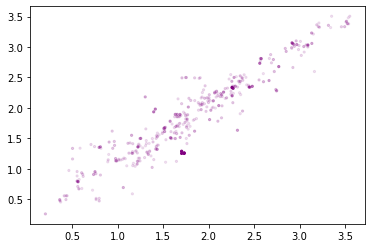

In [19]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 1e6

# plot points with transparency depending on size of trade
def drawpoints(target, preds, tdf):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (tdf.dollerr.abs() > threshold/10) # save time by not plotting points that would be invisible
    keep = keep & ~pd.isnull(tdf.rating)
    w = np.minimum( np.array(tdf.dollerr[keep].abs()), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(target[keep], preds[keep], s=5, c=color)
    
plt.figure()
drawpoints(vanilla[TARGET], vanilla.predicted, vanilla)

The most prominent cluster of large errors includes bonds whose obligor is the Ohio Valley Electric Corporation,
and AAA-rated bonds with 28 years to maturity from the University of Texas.
The yield on these bonds (over 1.7%) is higher than predicted (under 1.3%).

In [20]:
anom = (vanilla[TARGET] > 1.7) & (vanilla.predicted < 1.3) & (vanilla.dollerr.abs() > 1e5)
vanilla[anom]

,cusip,num_prev_messages,when_issued,brokers_broker,is_ATS,is_NTBC,obligor,callable_at_cav,issue_size,issue_amount,security_type,enhancement,purpose,purpose_sub,trade_date,trade_type,par_traded,dollar_price,yield,yield_spread,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,rating,issuer,is_LOPT,state,description,primary,is_GO,capital_type,use_of_proceeds,tax_status,alert,my_price,my_date,yrs_to_call,yrs_to_par_call,yrs_to_maturity,call_to_maturity,days_to_settle,days_to_refund,zerocoupon,deferred,last_date,yrs_to_end,price_delta,cusip6,proxy,predicted,delta,dollerr
16012,45505VAD8,0,False,NaN,False,False,OHIO VALLEY ELEC CORP,False,50000000.0,50000000.0,8,NaN,28.0,28.0,2021-01-26,S,2000000.0,107.810,2.110,1.712750,3.0,2.0,2010-12-16,2021-01-28,2020-11-01,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2030-11-01,NaN,INDIANA ST FIN AUTH POLLUTION CTL REV,False,IN,INDIANA ST FIN AUTH POLLUTION CTL REV OHIO VY ...,BDS 2010 A,False,8,35,2,False,107.810,maturity,NaN,NaN,9.757700,NaN,2.0,NaN,False,False,2030-11-01,9.757700,0.000,45505V,True,0.972060,0.740690,1.445486e+05
611,45470CAE9,0,False,NaN,False,False,OHIO VALLEY ELEC CORP,False,50000000.0,100000000.0,8,NaN,20.0,28.0,2021-01-26,P,3000000.0,107.535,2.140,1.742750,3.0,2.0,2012-06-28,2021-01-28,2020-11-01,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2030-11-01,NaN,INDIANA FIN AUTH MIDWESTERN DISASTER RELIEF REV,False,IN,INDIANA FIN AUTH MIDWESTERN DISASTER RELIEF RE...,BDS 2012 B,False,8,59,2,False,107.536,maturity,NaN,NaN,9.757700,NaN,2.0,NaN,False,False,2030-11-01,9.757700,0.001,45470C,True,0.906213,0.836537,2.448803e+05
3716,45505VAD8,0,False,NaN,False,False,OHIO VALLEY ELEC CORP,False,50000000.0,50000000.0,8,NaN,28.0,28.0,2021-01-26,P,2000000.0,107.535,2.140,1.742750,3.0,2.0,2010-12-16,2021-01-28,2020-11-01,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2030-11-01,NaN,INDIANA ST FIN AUTH POLLUTION CTL REV,False,IN,INDIANA ST FIN AUTH POLLUTION CTL REV OHIO VY ...,BDS 2010 A,False,8,35,2,False,107.536,maturity,NaN,NaN,9.757700,NaN,2.0,NaN,False,False,2030-11-01,9.757700,0.001,45505V,True,0.961797,0.780952,1.524060e+05
14368,45470CAE9,0,False,NaN,False,False,OHIO VALLEY ELEC CORP,False,50000000.0,100000000.0,8,NaN,20.0,28.0,2021-01-26,S,3000000.0,107.810,2.110,1.712750,3.0,2.0,2012-06-28,2021-01-28,2020-11-01,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2030-11-01,NaN,INDIANA FIN AUTH MIDWESTERN DISASTER RELIEF REV,False,IN,INDIANA FIN AUTH MIDWESTERN DISASTER RELIEF RE...,BDS 2012 B,False,8,59,2,False,107.810,maturity,NaN,NaN,9.757700,NaN,2.0,NaN,False,False,2030-11-01,9.757700,0.000,45470C,True,0.884196,0.828554,2.425433e+05
18675,91514AJV8,1,False,NaN,False,False,None,False,258715000.0,318715000.0,8,NaN,9.0,87.0,2021-01-27,D,10000000.0,162.084,2.098,1.729921,5.0,2.0,2019-07-15,2021-01-29,2020-02-15,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2049-08-15,AAA,UNIVERSITY TEX UNIV REVS,False,TX,UNIVERSITY TEX UNIV REVS FING SYS-SER B,FING SYS BDS 2019 B,False,4,14,2,False,162.084,maturity,NaN,NaN,28.542094,NaN,2.0,NaN,False,False,2049-08-15,28.542094,0.000,91514A,False,1.252100,0.477821,1.363800e+06
22025,91514AJV8,1,False,NaN,False,False,None,False,258715000.0,318715000.0,8,NaN,9.0,87.0,2021-01-27,P,10000000.0,162.084,2.098,1.729921,5.0,2.0,2019-07-15,2021-01-29,2020-02-15,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2049-08-15,AAA,UNIVERSITY TEX UNIV REVS,False,TX,UNIVERSITY TEX UNIV REVS FING SYS-SER B,FING SYS BDS 2019 B,False,4,14,2,False,162.084,maturity,NaN,NaN,28.542094,NaN,2.0,NaN,False,False,2049-08-15,28.542094,0.000,91514A,False,1.260537,0.469384,1.339720e+06
2552,91514AJV8,1,False,NaN,False,False,None,False,258715000.0,318715000.0,8,NaN,9.0,87.0,2021-01-27,S,10000000.0,162.911,2.070,1.701921,5.0,2.0,2019-07-15,2021-01-29,2020-02-15,False,NaT,NaN,NaT,NaN,False,NaN,NaT,NaN,2049-08-15,AAA,UNIVERSITY TEX UNIV REVS,False,TX,UNIVERSITY